In [1]:
from pybedtools import BedTool
import pandas as pd

mm9 = pd.read_csv(
    'resource/mm9_assembly.tsv', 
    sep = '\t', 
    usecols = [1, 2, 3], 
    skiprows = 1, 
    header = None, 
    names = ['chrom', 'start', 'end']
)
mm9.sort_values(
    by = ['chrom', 'start', 'end'],
    inplace = True
)
bt = BedTool().from_dataframe(mm9)
mm9 = bt.merge()
mm9.head()

chr1	3000000	22414948
 chr1	22415048	22423349
 chr1	22473349	24686638
 chr1	24736638	75102130
 chr1	75118130	78603540
 chr1	78603640	78604724
 chr1	78605669	78606725
 chr1	78607360	78610454
 chr1	78610737	85343678
 chr1	87343678	145296547
 

In [2]:
#for excluding N-stretches from the bedgraphs
import pyBigWig as pb
conditions = ['lacz', 'mcmkd', 'rifkolacz', 'rifkomcmkd']

chroms = pd.read_csv(
    'resource/mm9.chr_lengths.txt', 
    sep = '\t', 
    header = None, 
    names = ['chrom', 'size']
).sort_values(by = 'chrom')

mm9_chroms = [(c, s) for c, s in chroms.values]
for cond in conditions:
    print(cond)
    bg_df = pd.read_csv(
        f'../bedgraphs/{cond}_rt_20kb.bg', 
        sep = '\t', 
        header = None, 
        names = ['chrom', 'start', 'end', 'value']
    ).sort_values(by = ['chrom', 'start', 'end']) \
    .reset_index(drop = True)
    bg_bt = BedTool().from_dataframe(bg_df)
    bg_df = bg_bt \
        .intersect(mm9, u = True) \
        .to_dataframe(names = ['chrom', 'start', 'end', 'value'])

    bw = pb.open(f'../bigwigs/{cond}_rt_20kb.bw', 'w')
    bw.addHeader(mm9_chroms)
    bw.addEntries(
        list(bg_df.chrom.values), 
        list(bg_df.start.values), 
        ends = list(bg_df.end.values), 
        values = list(bg_df.value.values)
    )
    bw.close()

lacz
mcmkd
rifkolacz
rifkomcmkd


In [3]:
import numpy as np
def read_bg_and_add_bw(bg, bw):
    df = pd.read_csv(bg, 
                     header = None,
                     usecols = [0, 1, 2, 3],
                     names = ['chrom', 'start', 'end', 'domain'],
                     sep = '\t')
    
    bw = pb.open(bw)
    
    def get_mean_bw_value(x, bw):
        intervals = bw.intervals(x['chrom'], x['start'], x['end'])
        if not intervals:
            return np.nan
        
        else:
            values = np.array([i[-1] for i in intervals])
            return values.mean()
    
    df['bw_value'] = df.apply(get_mean_bw_value, axis = 1, bw = bw)
    return df


def assign_domain_names(df, names, split_domain = {}):
    '''
    names has to contain the expected domain names in the order from low value to high value
    split_domains takes a dictionary with the domain_names as keys and a tuple containing 
    (split_value, smaller_split_name, greater_split_name)
    '''
    domains = []
    for domain, group in df.groupby('domain'):
        domains.append((group.bw_value.mean(), domain))
    
    domains = sorted(domains, key = lambda x: x[0])
    domain2name = {domain[1]: name for domain, name in zip(domains, names)}
    
    df['domain_name'] = df.domain.apply(lambda x: domain2name[x])
    
    if split_domain:
        for domain_name, (split_value, smaller_split_name, greater_split_name) in split_domain.items():
            df.loc[(df.domain_name == domain_name) & (df.bw_value < split_value), 'domain_name'] = smaller_split_name
            df.loc[(df.domain_name == domain_name) & (df.bw_value >= split_value), 'domain_name'] = greater_split_name
    
    return df

conditions = ['lacz', 'mcmkd', 'rifkolacz', 'rifkomcmkd']
hmms = {
    cond: read_bg_and_add_bw(
        f'../hmm/{cond}_rt_20kb_3_state_HMM_colored.bed', 
        f'../bigwigs/{cond}_rt_20kb.bw') 
    for cond in conditions
}
domain_names = ['L', 'M', 'E']
for cond in conditions:
    hmms[cond]['length'] = hmms[cond].end - hmms[cond].start
    hmms[cond] = assign_domain_names(
        hmms[cond], 
        domain_names
    )

In [4]:
hmms['lacz']

,chrom,start,end,domain,bw_value,length,domain_name
0,chr1,0,3000000,1,NaN,3000000,M
1,chr1,3000000,4300000,0,-2.280849,1300000,L
2,chr1,4300000,5080000,1,-0.076227,780000,M
3,chr1,5080000,6100000,0,-2.524693,1020000,L
4,chr1,6100000,7320000,1,1.523724,1220000,M
...,...,...,...,...,...,...,...
2620,chrX,163820000,164060000,1,1.246951,240000,M
2621,chrX,164060000,164700000,0,-2.305294,640000,L
2622,chrX,164700000,164960000,1,-0.908785,260000,M
2623,chrX,164960000,165480000,0,-1.966687,520000,L


In [5]:
def expand_bins(df, resolution, value_col):
    df = df.copy()
    expandables = (df.end - df.start) > resolution
    expanded = []
    for i, bin_ in df[expandables].iterrows():
        for j in range((bin_['end'] - bin_['start'])//resolution):
            expanded.append([bin_['chrom'], 
                             bin_['start'] + resolution*j, 
                             bin_['start'] + resolution*(j+1), bin_[value_col]])
            
    df.drop(df[expandables].index, axis = 'index', inplace = True)
    
    expandedDf = pd.DataFrame(expanded,
                              columns = ['chrom', 'start', 'end', value_col])
    
    df = df.merge(expandedDf, 
                  on = ['chrom', 'start', 'end'], 
                  how = 'outer',
                  sort = True) \
           .rename(columns = {value_col + '_x': value_col})
    
    df.loc[:, value_col] = df[value_col].fillna(df[value_col + '_y'])
    return df.drop(value_col + '_y', axis = 'columns')


def get_bw_value(x, bw):
    interval = bw.intervals(x.chrom, x.start, x.end)
    return interval[0][-1] if interval else np.nan


expanded_hmms = {}
bwfile = '../bigwigs/{0}_rt_20kb.bw'
for cond in conditions:
    print(cond)
    df = expand_bins(
        hmms[cond], 
        20000, 
        'domain_name'
    )

    bw = pb.open(bwfile.format(cond))

    df.loc[:, 'bw_value'] = df.apply(
        get_bw_value, 
        axis = 1, 
        bw = bw
    )
    expanded_hmms[cond] = df.loc[~df.bw_value.isna()]

lacz
mcmkd
rifkolacz
rifkomcmkd


In [6]:
expanded_hmms['lacz']

,chrom,start,end,domain,bw_value,length,domain_name
150,chr1,3000000,3020000,NaN,-2.237077,NaN,L
151,chr1,3020000,3040000,NaN,-2.300855,NaN,L
152,chr1,3040000,3060000,NaN,-2.349630,NaN,L
153,chr1,3060000,3080000,NaN,-2.384971,NaN,L
154,chr1,3080000,3100000,NaN,-2.405668,NaN,L
...,...,...,...,...,...,...,...
131933,chrX,166520000,166540000,NaN,1.493080,NaN,M
131935,chrX,166560000,166580000,NaN,1.597817,NaN,M
131936,chrX,166580000,166600000,NaN,1.502859,NaN,M
131937,chrX,166600000,166620000,NaN,1.266289,NaN,M


In [7]:
def split_and_relabel_domain(df, old_domain, split_domains, split_value):
    df = df.copy()
    group_df = df.groupby('domain_name')
    group = group_df.get_group(old_domain)
    loweridx = group[group.bw_value < split_value].index
    higheridx = group[group.bw_value >= split_value].index
    
    for index, new_name in zip([loweridx, higheridx], split_domains):
        df.loc[index, 'domain_name'] = new_name
        
    return df

renamed_hmms = {}
split_domains = ('L-like', 'E-like')
for cond in conditions:
    renamed_hmms[cond] = split_and_relabel_domain(
        expanded_hmms[cond], 
        'M', 
        split_domains, 
        0
    )

In [8]:
renamed_hmms['lacz']

,chrom,start,end,domain,bw_value,length,domain_name
150,chr1,3000000,3020000,NaN,-2.237077,NaN,L
151,chr1,3020000,3040000,NaN,-2.300855,NaN,L
152,chr1,3040000,3060000,NaN,-2.349630,NaN,L
153,chr1,3060000,3080000,NaN,-2.384971,NaN,L
154,chr1,3080000,3100000,NaN,-2.405668,NaN,L
...,...,...,...,...,...,...,...
131933,chrX,166520000,166540000,NaN,1.493080,NaN,E-like
131935,chrX,166560000,166580000,NaN,1.597817,NaN,E-like
131936,chrX,166580000,166600000,NaN,1.502859,NaN,E-like
131937,chrX,166600000,166620000,NaN,1.266289,NaN,E-like


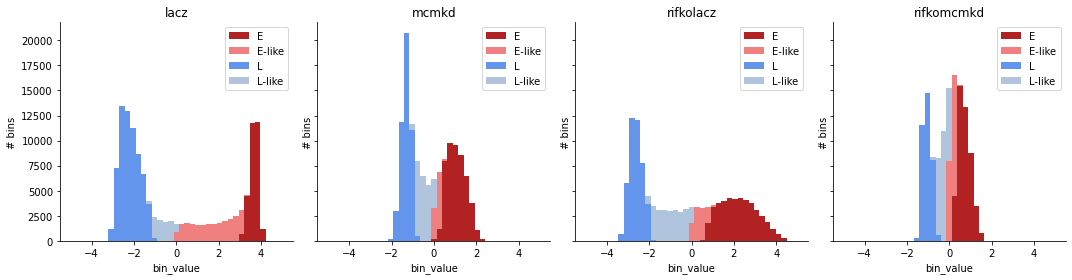

In [9]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(1, 4, sharey = 'row')
import seaborn as sb
xlims = {
    'lacz': (-5, 5), 
    'mcmkd': (-5, 5), 
    'rifkolacz': (-5, 5), 
    'rifkomcmkd': (-5, 5)
}
# colors = {
#     'E': 'firebrick', 
#     'E-like': 'lightcoral', 
#     'L' : 'cornflowerblue', 
#     'L-like': 'lightsteelblue'
# }
colors = ['firebrick', 'lightcoral', 'cornflowerblue', 'lightsteelblue']
for ax, cond in zip(axs, conditions):
    df = renamed_hmms[cond]
    x, domains = [], []
    for domain, group in df.groupby(f'domain_name'):
        domains.append(domain)
        x.append(group[f'bw_value'].values)

    ax.hist(
        x, 
        np.linspace(*xlims[cond], 40), 
        stacked = True,
        label = domains,
        color = colors[:len(domains)]
    )

    ax.legend()
    ax.set_title(f'{cond}')
    ax.set_xlabel('bin_value')
    ax.set_ylabel('# bins')

    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)

fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig('rt_hmm_partition.pdf')

In [10]:
from pybedtools import BedTool
from functools import reduce

merged_hmms = {}
for cond in conditions:
    df1 = hmms[cond].loc[:, ['chrom', 'start', 'end', 'domain', 'length']]
    df1.sort_values(by = ['chrom', 'start', 'end'], inplace = True)
    df1_columns = ['chrom', 'start', 'end', 'domain', 'length']
    intersects = []
    for othercond in conditions:
        print(othercond)
        df2 = renamed_hmms[othercond].loc[:, ['chrom', 'start', 'end', 'bw_value', 'domain_name']]
        for new_col, old_col in [('bin_chrom', 'chrom'), ('bin_start', 'start'), ('bin_end', 'end')]:
            df2[new_col] = df2.loc[:, old_col]

        df2.sort_values(by = ['chrom', 'start', 'end'], inplace = True)
        bt1 = BedTool().from_dataframe(df1)
        bt2 = BedTool().from_dataframe(df2)
        intersect = bt1 \
            .intersect(bt2, wo = True, sorted = True) \
            .to_dataframe(
                names = [
                    'chrom', 'start', 'end', 'domain', 'length',
                    'c', 's', 'e', 'bw_value', 'domain_name', 
                    'bin_chrom', 'bin_start', 'bin_end', 'overlap'
                ]
            )

        intersects.append(
            (
                '_' + othercond, intersect.loc[
                    :, 
                    [
                        'chrom', 'start', 'end', 'domain', 
                        'bin_chrom', 'bin_start', 'bin_end', 
                        'bw_value', 'domain_name', 'length'
                    ]
                ]
            )
        )
    _, merged_intersects = reduce(
        lambda left, right: (
            right[0], 
            pd.merge(
                left[1], 
                right[1], 
                on = [
                    'chrom', 'chrom', 'start', 'end', 'domain', 
                    'bin_chrom', 'bin_start', 'bin_end', 'length'
                ],
                how = 'left',
                suffixes = [left[0], right[0]])
        ),
        intersects
    )

    for col in merged_intersects.columns[merged_intersects.columns.str.startswith('bw')]:
        merged_intersects.loc[:, col] = merged_intersects[col].replace('.', np.nan).astype(float)

    merged_hmms[cond] = merged_intersects

lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd


In [11]:
reference = 'lacz'
comparison_conditions = ['mcmkd', 'rifkolacz', 'rifkomcmkd']
domain_names = ['L', 'L-like', 'E-like', 'E']
deltas = {}
ref_df = merged_hmms[reference]
ref_df = ref_df[ref_df['length'] > 100000]
for domain in domain_names:
    deltas[domain] = {}
    domain_ref_df = ref_df[ref_df[f'domain_name_{reference}'] == domain]
    #for (chrom, start, end, length), group in domain_ref_df.groupby(['chrom', 'start', 'end', 'length']):
        #for cond in conditions:
            #deltas[hmmtype][domain][cond] = group[f'bw_value_{cond}']
    for cond in conditions:
        deltas[domain][cond] = domain_ref_df[f'bw_value_{cond}']

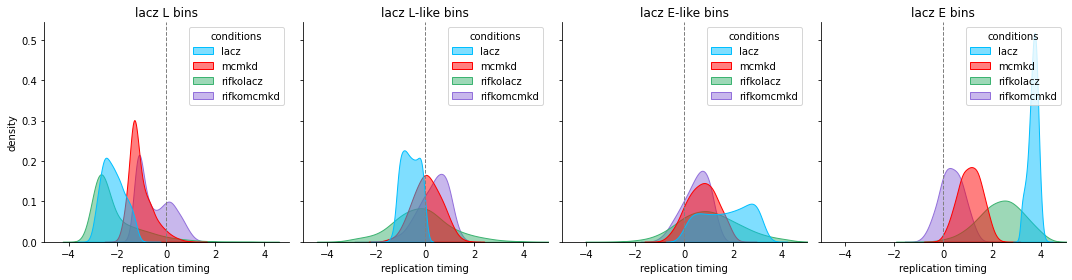

In [ ]:
fig, axs = plt.subplots(1, 4, sharey = 'row')
import seaborn as sb

clips = [(-5, 5), (-3, 3), (-5, 5), (-3, 3)]
colors = ['deepskyblue', 'red', 'mediumseagreen', 'mediumpurple']
for ax, domain in zip(axs, domain_names):
    ax.set_title(f'{reference} {domain} bins')
    data = []
    for cond in conditions:
        df = pd.DataFrame(
            {
                'rt': deltas[domain][cond].values,
                'conditions': [cond for i in deltas[domain][cond]]
            }
        )
        data.append(df)

    data = pd.concat(data)
    sb.kdeplot(
        data = data,
        x = 'rt',
        hue = 'conditions',
        bw_adjust = 2,
        ax = ax,
        fill = True,
        alpha = 0.5,
        palette = colors,
        legend = True
    )  

    ax.set_xlim(-5, 5)
    ax.axvline(0, ls = '--', color = 'grey', lw = 1)
    ax.set_xlabel('replication timing')
    ax.set_ylabel('density')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)

fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig('rt_bin_change.pdf')

# H3K9me3 enrichment on RT switches

In [26]:
def get_bw_value(x, bw):
    interval = bw.intervals(x.bin_chrom, x.bin_start, x.bin_end)
    return interval[0][-1] if interval else np.nan


h3k9me3_template_string = '/groups/pavri/bioinfo/daniel/rifh3k09me3/bigwigs20kb/h3k09me3_{0}.spike.bw'
h3k9_bw_files = {
    'lacz': h3k9me3_template_string.format('shLacZ'),
    'mcmkd': h3k9me3_template_string.format('shMcm'),
    'rifkolacz': h3k9me3_template_string.format('Rif1ko'),
    'rifkomcmkd': h3k9me3_template_string.format('Rif1ko_shMcm')
}


merged_hmm = merged_hmms['lacz'].copy()
for cond in conditions:
    bw = pb.open(h3k9_bw_files[cond], 'r')
    merged_hmm[cond + '_h3k9me3'] = merged_hmm.apply(
        get_bw_value,
        axis = 1,
        bw = bw
    )

In [27]:
merged_hmm

,chrom,start,end,domain,bin_chrom,bin_start,bin_end,bw_value_lacz,domain_name_lacz,length,bw_value_mcmkd,domain_name_mcmkd,bw_value_rifkolacz,domain_name_rifkolacz,bw_value_rifkomcmkd,domain_name_rifkomcmkd,lacz_h3k9me3,mcmkd_h3k9me3,rifkolacz_h3k9me3,rifkomcmkd_h3k9me3
0,chr1,3000000,4300000,0,chr1,3000000,3020000,-2.237077,L,1300000,-1.427270,L,-3.068296,L,-0.807760,L,37.297401,64.866699,46.402100,38.858299
1,chr1,3000000,4300000,0,chr1,3020000,3040000,-2.300855,L,1300000,-1.391553,L,-2.971272,L,-0.828216,L,44.342499,73.394501,50.442699,52.516998
2,chr1,3000000,4300000,0,chr1,3040000,3060000,-2.349630,L,1300000,-1.360552,L,-2.895187,L,-0.845940,L,45.482201,65.705498,48.226898,47.011200
3,chr1,3000000,4300000,0,chr1,3060000,3080000,-2.384971,L,1300000,-1.336669,L,-2.842057,L,-0.857672,L,42.477600,68.082100,48.487598,42.352402
4,chr1,3000000,4300000,0,chr1,3080000,3100000,-2.405668,L,1300000,-1.319892,L,-2.807933,L,-0.867348,L,41.545200,65.286102,49.530300,39.493599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128178,chrX,165480000,166650296,1,chrX,166520000,166540000,1.493080,E-like,1170296,0.776709,E,NaN,NaN,-0.348772,L-like,31.702801,44.176498,45.359402,35.576000
128179,chrX,165480000,166650296,1,chrX,166560000,166580000,1.597817,E-like,1170296,1.138383,E,NaN,NaN,-0.370970,L-like,8.495530,16.636101,16.944599,16.517401
128180,chrX,165480000,166650296,1,chrX,166580000,166600000,1.502859,E-like,1170296,1.232938,E,NaN,NaN,-0.322156,L-like,37.608299,57.597198,71.819000,66.387398
128181,chrX,165480000,166650296,1,chrX,166600000,166620000,1.266289,E-like,1170296,1.223870,E,NaN,NaN,-0.230442,L-like,34.603699,66.823898,79.639603,70.622597


In [28]:
merged_hmm = merged_hmm.drop(
    index = merged_hmm.index[
        pd.isna(
            merged_hmm[['domain_name_mcmkd', 'domain_name_rifkolacz', 'domain_name_rifkomcmkd']]
        ).any(axis = 1)
    ]
)
merged_hmm

,chrom,start,end,domain,bin_chrom,bin_start,bin_end,bw_value_lacz,domain_name_lacz,length,bw_value_mcmkd,domain_name_mcmkd,bw_value_rifkolacz,domain_name_rifkolacz,bw_value_rifkomcmkd,domain_name_rifkomcmkd,lacz_h3k9me3,mcmkd_h3k9me3,rifkolacz_h3k9me3,rifkomcmkd_h3k9me3
0,chr1,3000000,4300000,0,chr1,3000000,3020000,-2.237077,L,1300000,-1.427270,L,-3.068296,L,-0.807760,L,37.297401,64.866699,46.402100,38.858299
1,chr1,3000000,4300000,0,chr1,3020000,3040000,-2.300855,L,1300000,-1.391553,L,-2.971272,L,-0.828216,L,44.342499,73.394501,50.442699,52.516998
2,chr1,3000000,4300000,0,chr1,3040000,3060000,-2.349630,L,1300000,-1.360552,L,-2.895187,L,-0.845940,L,45.482201,65.705498,48.226898,47.011200
3,chr1,3000000,4300000,0,chr1,3060000,3080000,-2.384971,L,1300000,-1.336669,L,-2.842057,L,-0.857672,L,42.477600,68.082100,48.487598,42.352402
4,chr1,3000000,4300000,0,chr1,3080000,3100000,-2.405668,L,1300000,-1.319892,L,-2.807933,L,-0.867348,L,41.545200,65.286102,49.530300,39.493599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120024,chr9,123860000,124060000,2,chr9,123960000,123980000,3.926852,E,200000,1.118906,E,3.840509,E,0.333069,E,14.815400,30.476200,31.673300,20.117399
120025,chr9,123860000,124060000,2,chr9,123980000,124000000,3.857352,E,200000,1.237414,E,3.753151,E,0.399990,E,18.648701,32.573200,34.410599,27.740801
120026,chr9,123860000,124060000,2,chr9,124000000,124020000,3.738373,E,200000,1.368672,E,3.603575,E,0.480155,E,17.716299,31.175200,34.931900,27.952600
120027,chr9,123860000,124060000,2,chr9,124020000,124040000,3.562510,E,200000,1.504341,E,3.363971,E,0.574218,E,13.364900,25.163799,34.671200,22.658501


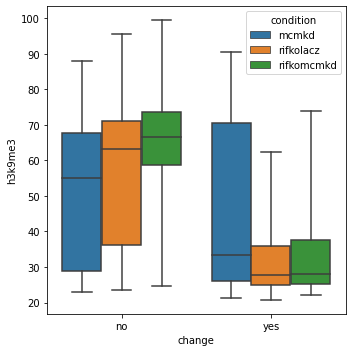

In [56]:
data = pd.DataFrame(columns = ['condition', 'h3k9me3', 'change'])
for treatment, reference in [('mcmkd', 'lacz'), ('rifkolacz', 'lacz'), ('rifkomcmkd', 'rifkolacz')]:
    unchanged_bins = []
    for hmm_state in ['L', 'L-like']:
        unchanged = merged_hmm.loc[
            (merged_hmm[f'domain_name_{reference}'] == hmm_state) & (merged_hmm[f'domain_name_{treatment}'] == hmm_state), 
            [f'{cond}_h3k9me3']
        ]
        
        unchanged['condition'] = treatment
        unchanged['change'] = 'no'
        unchanged.columns = ['h3k9me3', 'condition', 'change']
        unchanged_bins.append(unchanged)
    
    unchanged = pd.concat(unchanged_bins)
        
    changed_bins = []
    for reference_hmm_state, earlier_hmm_states in zip(
        ['L', 'L-like'], 
        [('L-like', 'E-like', 'E'), ('E-like', 'E')]
    ):
        changed = merged_hmm.loc[
            (merged_hmm[f'domain_name_{reference}'] == reference_hmm_state) & \
            merged_hmm[f'domain_name_{treatment}'].isin(earlier_hmm_states), 
            [f'{cond}_h3k9me3']
        ]
        changed['condition'] = treatment
        changed['change'] = 'yes'
        changed.columns = ['h3k9me3', 'condition', 'change']
        changed_bins.append(changed)
    
    changed = pd.concat(changed_bins)
    data = pd.concat([data, unchanged, changed])
    
data

import seaborn as sns
fig, ax = plt.subplots()

sns.boxplot(
    data = data,
    x = 'change',
    y = 'h3k9me3',
    hue = 'condition',
    ax = ax,
    showfliers = False,
    whis = [5, 95]
)

fig.set_figwidth(5)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('h3k9me3_rt_dependence_late.pdf')

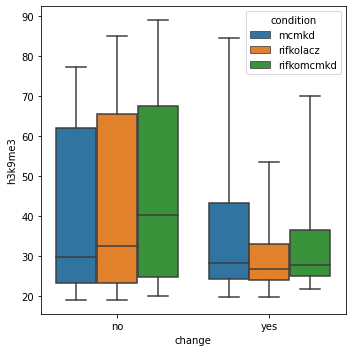

In [57]:
data = pd.DataFrame(columns = ['condition', 'h3k9me3', 'change'])
for treatment, reference in [('mcmkd', 'lacz'), ('rifkolacz', 'lacz'), ('rifkomcmkd', 'rifkolacz')]:
    unchanged_bins = []
    for hmm_state in ['L', 'L-like', 'E-like', 'E']:
        unchanged = merged_hmm.loc[
            (merged_hmm[f'domain_name_{reference}'] == hmm_state) & (merged_hmm[f'domain_name_{treatment}'] == hmm_state), 
            [f'{cond}_h3k9me3']
        ]
        
        unchanged['condition'] = treatment
        unchanged['change'] = 'no'
        unchanged.columns = ['h3k9me3', 'condition', 'change']
        unchanged_bins.append(unchanged)
    
    unchanged = pd.concat(unchanged_bins)
        
    changed_bins = []
    for reference_hmm_state, earlier_hmm_states in zip(
        ['L', 'L-like', 'E-like'], 
        [('L-like', 'E-like', 'E'), ('E-like', 'E'), ('E',)]
    ):
        changed = merged_hmm.loc[
            (merged_hmm[f'domain_name_{reference}'] == reference_hmm_state) & \
            merged_hmm[f'domain_name_{treatment}'].isin(earlier_hmm_states), 
            [f'{cond}_h3k9me3']
        ]
        changed['condition'] = treatment
        changed['change'] = 'yes'
        changed.columns = ['h3k9me3', 'condition', 'change']
        changed_bins.append(changed)
    
    changed = pd.concat(changed_bins)
    data = pd.concat([data, unchanged, changed])
    
data

import seaborn as sns
fig, ax = plt.subplots()

sns.boxplot(
    data = data,
    x = 'change',
    y = 'h3k9me3',
    hue = 'condition',
    ax = ax,
    showfliers = False,
    whis = [5, 95]
)

fig.set_figwidth(5)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('h3k9me3_rt_dependence_all.pdf')